# Modeling Eclipsing Binary Systems

The sample data are split into two sets taken years apart. However, **the binary system itself has a short period**. The main goal of the analysis is to estimate the sizes and effective temperatures of the stars from primary and secondary eclipse.

In the **Two Star Model**, the tidal distortions and star spots are negelected. Elliptical orbits are allowed. Any inclination angle and periastron angle are allowed.

Below is an simple exploration for the sample data given in Canvas.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from lightkurve import LightCurve
import warnings
warnings.filterwarnings("ignore")

In [4]:
def imp_data(name, dataType):
    if dataType == 'csv':
        data = pd.read_csv(name).dropna()
    elif dataType == 'txt':
        data = pd.read_table(name, delim_whitespace=True, usecols=[0, 1],
                             names=['JD', 'Mag'])
        data = data.apply(pd.to_numeric, errors='coerce')
        data = data.dropna()
    return data

In [5]:
def fill_gap(lightCurve, window, magnitude):
    timeSeries = np.linspace(window[0], window[1], 100)
    randMag = (np.random.rand(100) / 20) + magnitude
    for i in range(len(timeSeries)):
        lightCurve = lightCurve.append({'JD': timeSeries[i],
                                       'Mag': randMag[i]}, ignore_index=True)
    return lightCurve

In [6]:
def merge_data(lightCurve, shift, drift1, drift2):
    lightCurve[0]['JD'] = lightCurve[0]['JD'] + shift[0]
    lightCurve[1]['JD'] = lightCurve[1]['JD'] + shift[1]
    lightCurve[1]['Mag'] = lightCurve[1]['Mag'] + drift1
    lightCurve[2]['JD'] = lightCurve[2]['JD'] + shift[2]
    lightCurve[2]['Mag'] = lightCurve[2]['Mag'] + drift2
    merged_curve = lightCurve[0].append(lightCurve[1], ignore_index=True)
    merged_curve = merged_curve.append(lightCurve[2], ignore_index=True)
    return merged_curve

In [7]:
light_curve_1 = imp_data('LightCurve1.csv', 'csv')  # The Mystery Object

In [8]:
light_curve_2 = imp_data('SVCam.txt', 'txt')  # SV Cam
light_curve_22 = imp_data('SVCam4.txt', 'txt')  # SV Cam
light_curve_22 = light_curve_22[(light_curve_22['JD'] > 2458115.2) & (light_curve_22['JD'] < 2458115.4)]
light_curve_23 = imp_data('SVCam5.txt', 'txt')  # SV Cam
mergeEnsemble2 = [light_curve_2, light_curve_22, light_curve_23]
shiftEnsemble2 = [0, 303.06, 173.175]
light_curve_2 = merge_data(mergeEnsemble2, shiftEnsemble2, -0.07, -0.025)
light_curve_2 = fill_gap(light_curve_2, [2458418.57, 2458418.58], 9.35)

In [9]:
light_curve_3 = imp_data('HWVir.txt', 'txt')  # HW Vir

In [10]:
light_curve_41 = imp_data('QXAnd2.txt', 'txt')  # QX And
light_curve_42 = imp_data('QXAnd3.txt', 'txt')  # QX And
light_curve_43 = imp_data('QXAnd4.txt', 'txt')  # QX And
mergeEnsemble4 = [light_curve_41, light_curve_42, light_curve_43]
shiftEnsemble4 = [0, -31.945, -329.940]
light_curve_4 = merge_data(mergeEnsemble4, shiftEnsemble4, 0.003, 0)

In [11]:
def fold_Data(lightCurve, factor):
    # Instantiate the light curve object
    lc = LightCurve(time=lightCurve['JD'],
                    flux=lightCurve['Mag'],
                    time_format="btjd")
    # Visualize the raw data
    lc.scatter().invert_yaxis()
    plt.grid(color='gray', alpha=0.3)
    plt.title('Unfolded Light Curve')

    # create a periodogram using a specified factor
    pg_final = lc.to_periodogram(oversample_factor=factor)
    # save the period that corresponds the max power
    period = pg_final.period_at_max_power
    pg_final.plot()
    plt.title('Periodogram')
    plt.grid(color='gray', alpha=0.3)

    # fold using an integer multiple of the period from the periodogram
    folded_lc = lc.fold(period).bin(binsize=1)
    folded_lc.scatter().invert_yaxis()

    # add more feautures to the plot
    plt.minorticks_on()
    plt.tick_params(direction='in', length=8, width=1, labelsize=10,
                    right=True, top=True)
    plt.tick_params(direction='in', length=3, width=0.5, which='minor',
                    right=True, top=True)
    plt.title(f"Folded Light Curve with Period {period:.3f}")
    plt.grid(color='gray', alpha=0.3)
    plt.show()

    return period, folded_lc, lc

In [12]:
def transit_depth(lightCurve, depth, duration):
    # record the primary transit depth and the secondary transit depth
    primaryDepth = depth[1] - depth[0]  # top minus bottom
    secondDepth = depth[3] - depth[2]
    primaryDur = duration[1] - duration[0]
    secondDur = duration[3] - duration[2]

    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(16, 8)
    ax.plot(lightCurve['time'].value, lightCurve['flux'].value, 'ok')

    ax.axhline(y=depth[0], color='r', linestyle='--')
    ax.axhline(y=depth[1], color='r', linestyle='--')
    ax.axhline(y=depth[2], color='g', linestyle='--')
    ax.axhline(y=depth[3], color='g', linestyle='--')

    ax.axvline(x=duration[0], color='r', linestyle='-')
    ax.axvline(x=duration[1], color='r', linestyle='-')
    ax.axvline(x=duration[2], color='g', linestyle='-')
    ax.axvline(x=duration[3], color='g', linestyle='-')

    ax.invert_yaxis()
    ax.set(xlabel='Phase[JD]', ylabel='Magnitude')
    ax.grid(color='gray', alpha=0.5)
    plt.show()

    return primaryDepth, secondDepth, primaryDur, secondDur

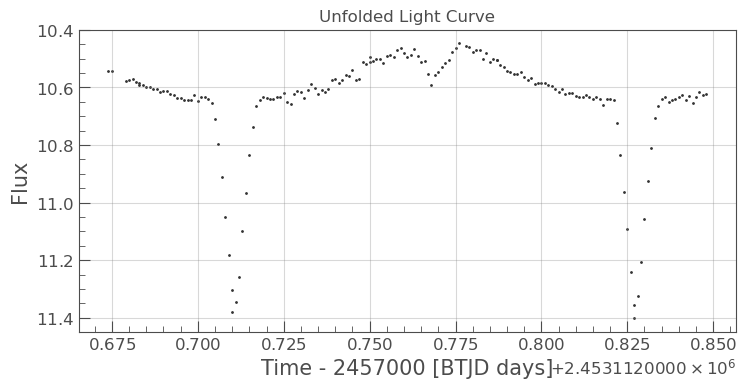

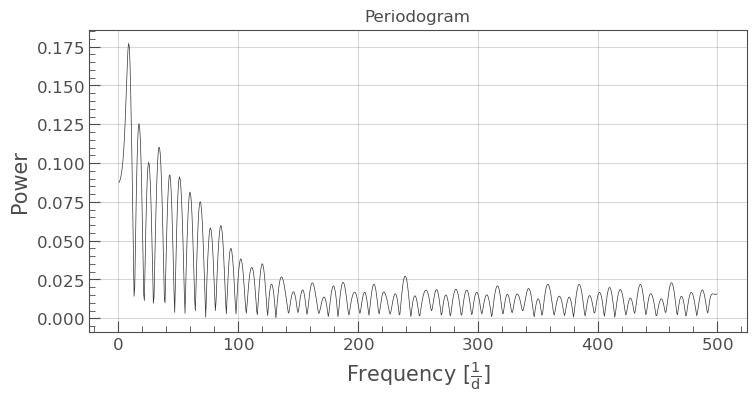

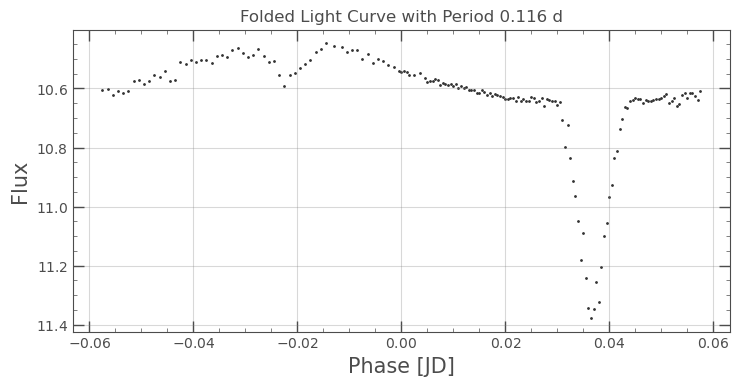

In [13]:
period_1, fold_curve_1, unfold_curve_1 = fold_Data(light_curve_1, 10)

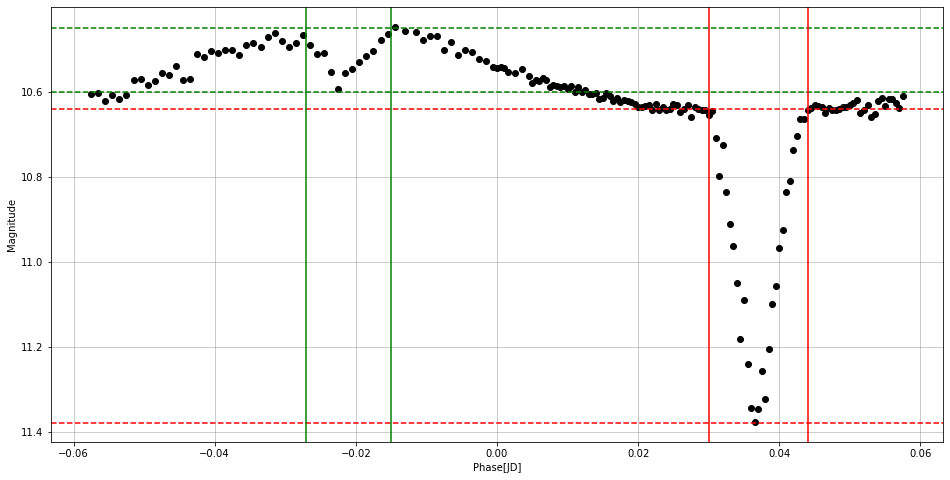

The period of the system is 0.116 d
The primary eclipse depth is 0.740 magnitudes
The secondary eclipse depth is 0.150 magnitudes
The primary eclipse duration is 0.014 days
The secondary eclipse duration is 0.012 days


In [14]:
# primary bottom, primary top
# secondary bottom, secondary top
depth_1 = [10.64, 11.38,
           10.45, 10.6]
# primary left, primary right
# secondary left, secondary right
duration_1 = [0.03, 0.044,
              -0.027, -0.015]
primDepth_1, secDepth_1, primDur_1, secDur_1 = transit_depth(fold_curve_1, depth_1, duration_1)
print(f"The period of the system is {period_1:.3f}")
print(f"The primary eclipse depth is {primDepth_1:.3f} magnitudes")
print(f"The secondary eclipse depth is {secDepth_1:.3f} magnitudes")
print(f"The primary eclipse duration is {primDur_1:.3f} days")
print(f"The secondary eclipse duration is {secDur_1:.3f} days")

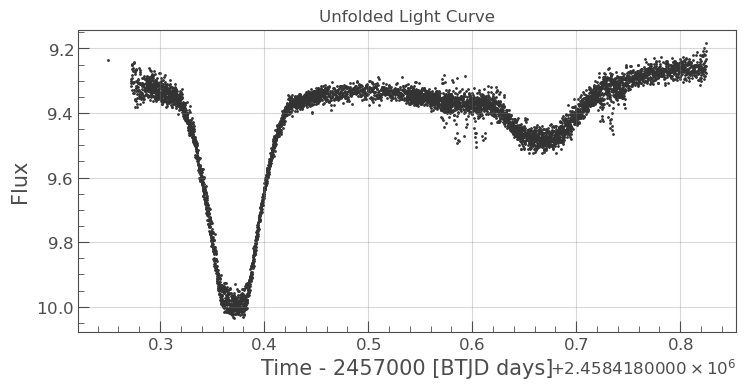

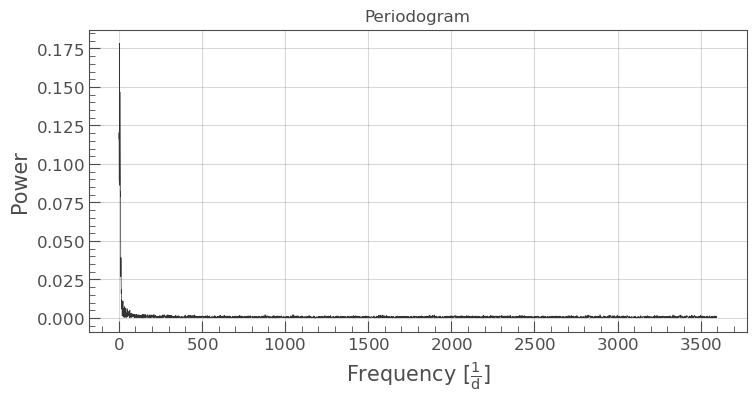

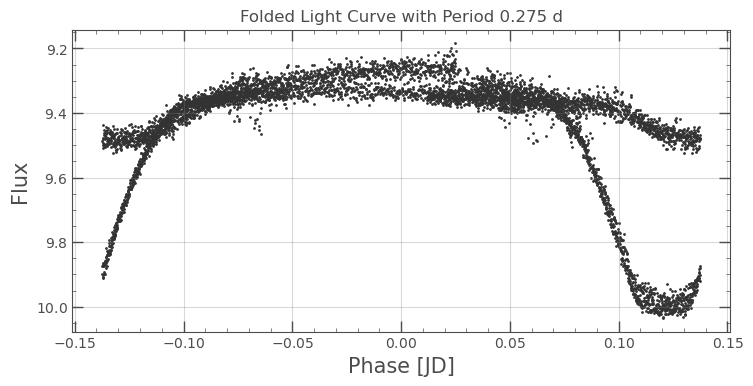

In [15]:
period_2, fold_curve_2, unfold_curve_2 = fold_Data(light_curve_2, 10)

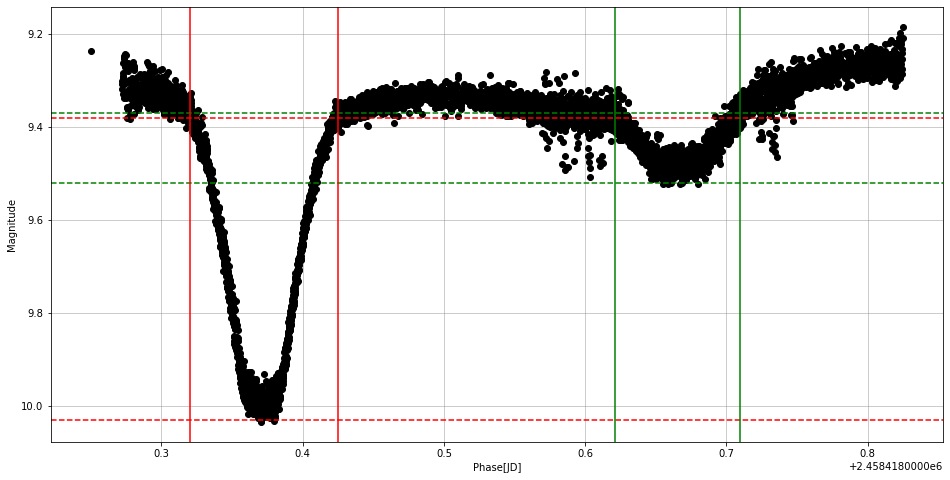

The period of the system is 0.550 d
The primary eclipse depth is 0.650 magnitudes
The secondary eclipse depth is 0.150 magnitudes
The primary eclipse duration is 0.105 days
The secondary eclipse duration is 0.089 days


In [32]:
# primary bottom, primary top
# secondary bottom, secondary top
depth_2 = [9.38, 10.03,
           9.37, 9.52]
# primary left, primary right
# secondary left, secondary right
duration_2 = [2458418.32, 2458418.425,
              2458418.621, 2458418.710]
primDepth_2, secDepth_2, primDur_2, secDur_2 = transit_depth(unfold_curve_2, depth_2, duration_2)
print(f"The period of the system is {2*period_2:.3f}")
print(f"The primary eclipse depth is {primDepth_2:.3f} magnitudes")
print(f"The secondary eclipse depth is {secDepth_2:.3f} magnitudes")
print(f"The primary eclipse duration is {primDur_2:.3f} days")
print(f"The secondary eclipse duration is {secDur_2:.3f} days")

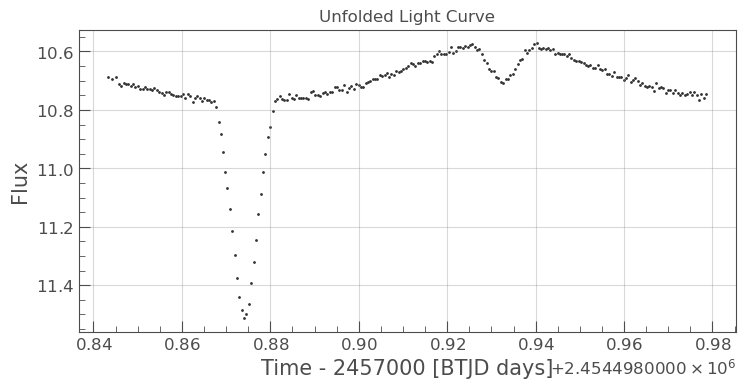

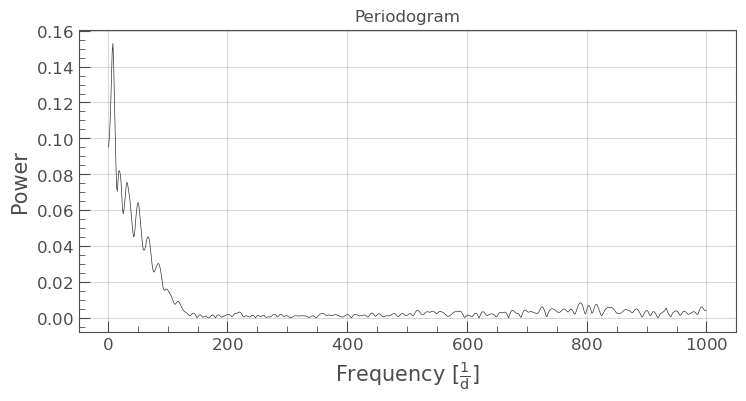

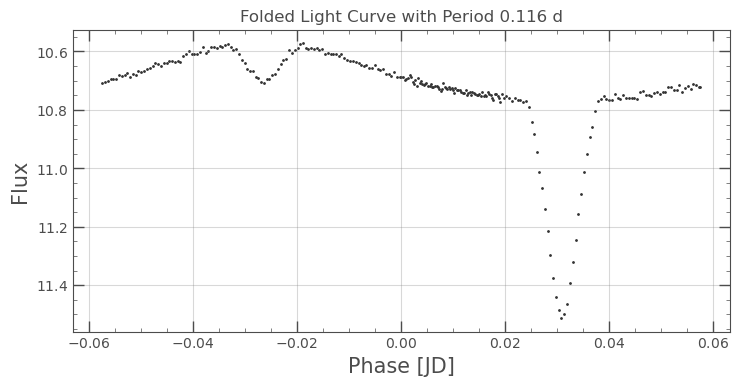

In [17]:
period_3, fold_curve_3, unfold_curve_3 = fold_Data(light_curve_3, 6)

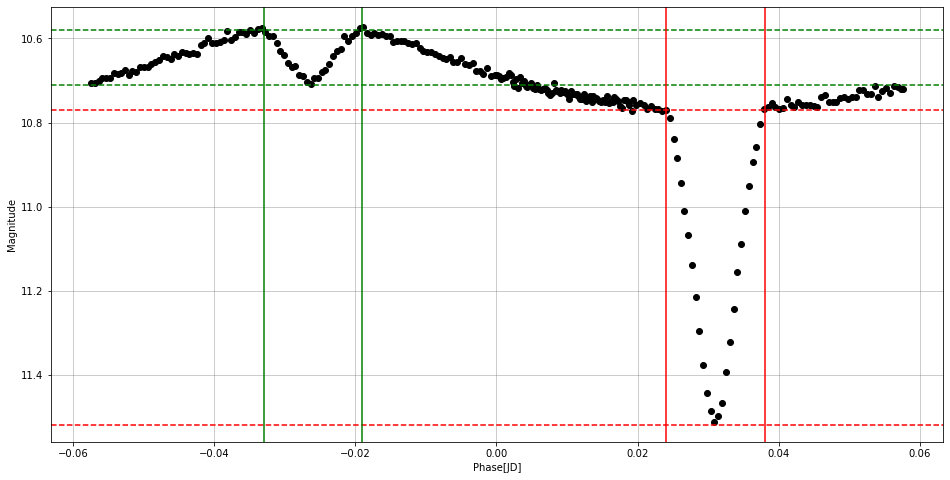

The period of the system is 0.116 d
The primary eclipse depth is 0.750 magnitudes
The secondary eclipse depth is 0.130 magnitudes
The primary eclipse duration is 0.014 days
The secondary eclipse duration is 0.014 days


In [18]:
# primary bottom, primary top
# secondary bottom, secondary top
depth_3 = [10.77, 11.52,
           10.58, 10.71]
# primary left, primary right
# secondary left, secondary right
duration_3 = [0.024, 0.038,
              -0.033, -0.019]
primDepth_3, secDepth_3, primDur_3, secDur_3 = transit_depth(fold_curve_3, depth_3, duration_3)
print(f"The period of the system is {period_3:.3f}")
print(f"The primary eclipse depth is {primDepth_3:.3f} magnitudes")
print(f"The secondary eclipse depth is {secDepth_3:.3f} magnitudes")
print(f"The primary eclipse duration is {primDur_3:.3f} days")
print(f"The secondary eclipse duration is {secDur_3:.3f} days")

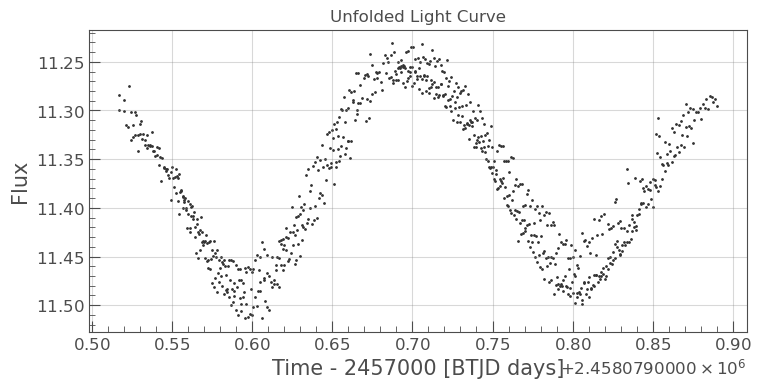

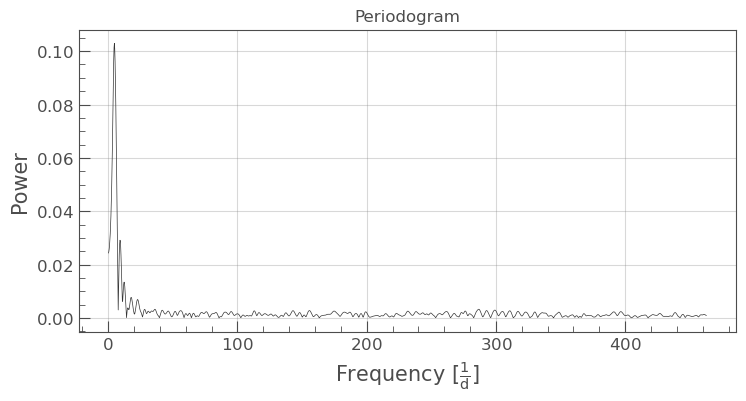

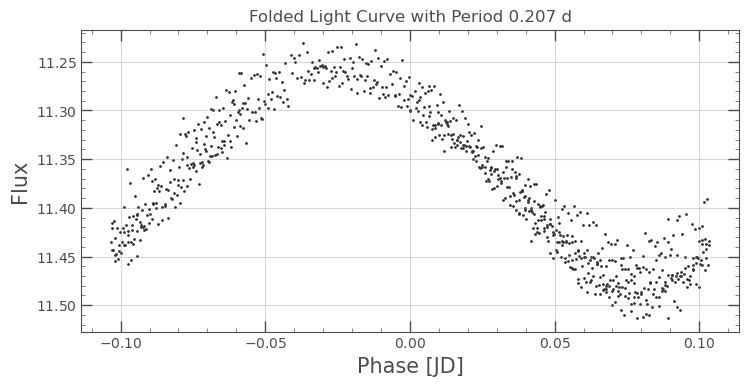

In [19]:
period_4, fold_curve_4, unfold_curve_4 = fold_Data(light_curve_4, 10)

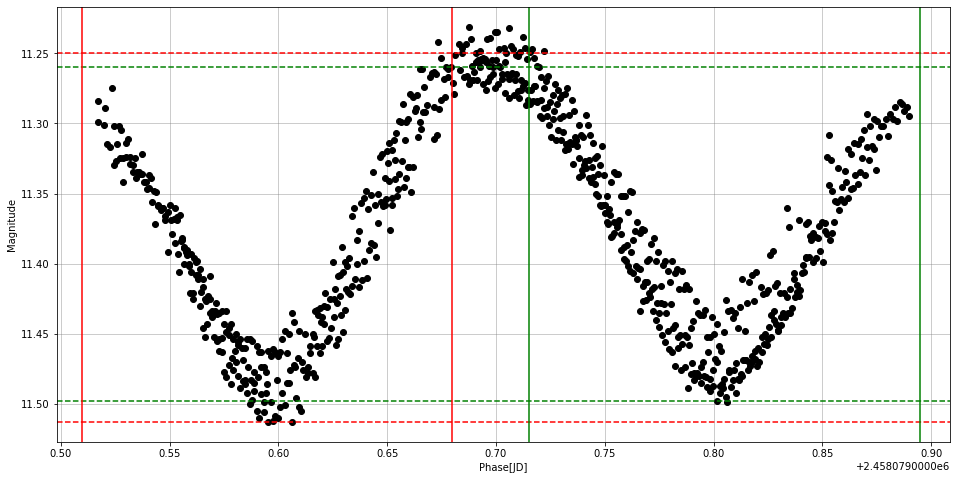

The period of the system is 0.414 d
The primary eclipse depth is 0.263 magnitudes
The secondary eclipse depth is 0.238 magnitudes
The primary eclipse duration is 0.170 days
The secondary eclipse duration is 0.180 days


In [20]:
# primary bottom, primary top
# secondary bottom, secondary top
depth_4 = [11.25, 11.513,
           11.26, 11.498]
# primary left, primary right
# secondary left, secondary right
duration_4 = [2458079.51, 2458079.68,
              2458079.715, 2458079.895]
primDepth_4, secDepth_4, primDur_4, secDur_4 = transit_depth(unfold_curve_4, depth_4, duration_4)
print(f"The period of the system is {2*period_4:.3f}")
print(f"The primary eclipse depth is {primDepth_4:.3f} magnitudes")
print(f"The secondary eclipse depth is {secDepth_4:.3f} magnitudes")
print(f"The primary eclipse duration is {primDur_4:.3f} days")
print(f"The secondary eclipse duration is {secDur_4:.3f} days")

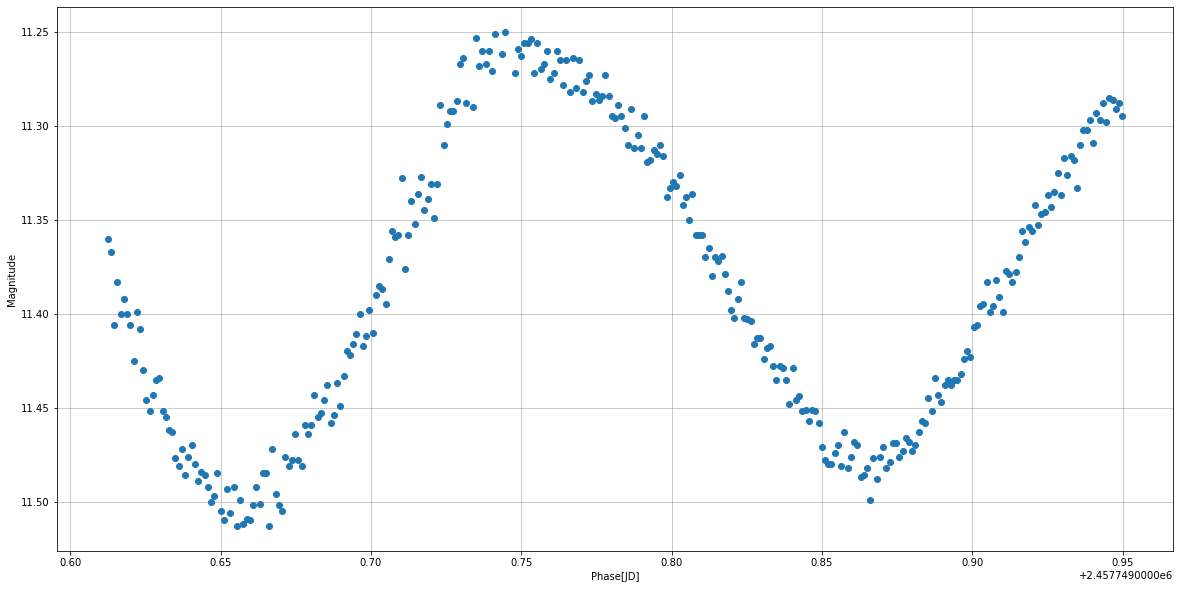

In [21]:
# Visualize the raw data
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(20, 10)
#ax.plot(light_curve_41['JD'], light_curve_41['Mag'], 'o')
#ax.plot(light_curve_42['JD']-31.945, light_curve_42['Mag']+0.03, 'o')
ax.plot(light_curve_43['JD']-329.940, light_curve_43['Mag'], 'o')
#ax.plot(light_curve_4['JD'], light_curve_4['Mag'], 'o')
ax.invert_yaxis()
ax.set(xlabel='Phase[JD]', ylabel='Magnitude')
ax.get_xaxis().get_major_formatter().set_scientific(False)
ax.grid(color='gray', alpha=0.5)
plt.show()

In [37]:
def temp_ratio(primDepth, secDepth):
    # Assume Star B is the heavier one
    # If Star A is hotter, then
    T_AB = ((1-10**(-primDepth/2.5))/(1-10**(-secDepth/2.5))) ** 0.25
    # If Star B is hotter, then
    T_BA = 1 / T_AB
    return T_AB, T_BA

In [41]:
ratio_1, ratio_2 = temp_ratio(primDepth_4, secDepth_4)
print(ratio_1)
print(ratio_2)

1.0224515122957885
0.9780414894732989


The transit duration helps us know the **relative sizes** of two stars.

The ratio of transit depths helps us know the **relative luminosity** of two stars.

These properties can help reduce computation time in the modeling.

Take the system above as an example, there is no obvious complete eclipse (i.e., flat bottom), it indicates that this system has some inclination angles relative to our line of sight.

What we do not know is:
1) Sum of masses and individual masses 
2) Semi-major axis 
3) Inclination Angle 
4) Radii of two stars

For the system of eclipsing binary stars, the inclination angles usually do not matter, and the indivial masses and temperatures of stars in the system are usually not exactly the same. Assume **Star B** is larger than **Star A**, and **Star A** is hotter than **Star B**: \
$\frac{L_O - L_P}{L_O - L_S} = \frac{\pi R^{2}_{A} \sigma T^{4}_{A}}{\pi R^{2}_{A} \sigma T^{4}_{B}}=(\frac{T_A}{T_B})^4$. The relationship between eclipse luminosity and the total luminosity can be given by to formula: \
$\frac{L_P}{L_O} = \frac{F_P}{F_O} = 10^{\frac{\Delta M}{2.5}}$  **AND**  $\frac{L_S}{L_O} = \frac{F_S}{F_O} = 10^{\frac{\Delta m}{2.5}}$. The relationship between their relative temperature can be calculated as: \
$(\frac{T_A}{T_B})^4 = \frac{1-10^{\frac{\Delta M}{2.5}}}{1-10^{\frac{\Delta m}{2.5}}} \rightarrow \frac{T_A}{T_B}=(\frac{1-10^{\frac{\Delta M}{2.5}}}{1-10^{\frac{\Delta m}{2.5}}})^{1/4}$. If **Star B** is hotter than **Star A**, then the result is reversed as $\frac{T_B}{T_A}=(\frac{1-10^{\frac{\Delta M}{2.5}}}{1-10^{\frac{\Delta m}{2.5}}})^{1/4}$\
The relationship between mass and semi-major axis is given as: $\frac{m_A}{m_B} = \frac{a_B}{a_A}.$ \
The time complexity for the modeling can be reduced to O(N^3) by using the following nested for loop: \
For every possible ratio between semi-major axis $\frac{a_B}{a_A} \rightarrow$ For every possible mass of $m_B \rightarrow$ For every possible temperature of Star B. **The individual radii of two stars do not matter; instead, which star is larger matters**.
